In [1]:
pip install torch torchvision

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import threading
import matplotlib.pyplot as plt
import random

Load and partition the CIFAR-10 Dataset

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [5]:
class FederatedClient(threading.Thread):
    def __init__(self, model, optimizer, train_loader):
        super(FederatedClient, self).__init__()
        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.training_losses = []  # to store training losses

    def run(self):
        self.train()

    def train(self):
        self.model.train()
        for epoch in range(3):  # Number of local epochs
            for batch_idx, (data, target) in enumerate(self.train_loader):
                self.optimizer.zero_grad()
                output = self.model(data)
                loss = F.nll_loss(output, target)
                loss.backward()
                self.optimizer.step()
                if batch_idx % 100 == 0:
                    print('Client Training Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, batch_idx * len(data), len(self.train_loader.dataset),
                        100. * batch_idx / len(self.train_loader), loss.item()))
                    self.training_losses.append(loss.item())

In [6]:
def federated_learning():
    # Define the global model
    global_model = SimpleCNN()

    # Load CIFAR-10 dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.CIFAR10('./data', train=False, download=True, transform=transform)

    # Take a smaller subset of the CIFAR-10 dataset
    random.seed(42)  # for reproducibility
    train_dataset = torch.utils.data.Subset(train_dataset, random.sample(range(len(train_dataset)), 5000))

    # Partition dataset among clients
    num_clients = 5
    client_datasets = random_split(train_dataset, [len(train_dataset) // num_clients] * num_clients)

    # Create and start federated clients
    clients = []
    for dataset in client_datasets:
        train_loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=0)  # Reduced num_workers
        model = SimpleCNN()
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        client = FederatedClient(model, optimizer, train_loader)
        clients.append(client)
        client.start()

    # Wait for all clients to finish training
    for client in clients:
        client.join()

    # Aggregate model parameters from all clients
    with torch.no_grad():
        for name, param in global_model.named_parameters():
            param.data.zero_()
        for client in clients:
            for name, param in client.model.named_parameters():
                global_param = global_model.state_dict()[name]
                global_param.add_(param.data / num_clients)

    # Evaluate the global model on a test dataset
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)  # Reduced num_workers

    global_model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = global_model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')

    # Plot the training losses
    plt.figure(figsize=(12, 5))
    for i, client in enumerate(clients):
        plt.plot(range(len(client.training_losses)), client.training_losses, label=f'Client {i+1}')
    plt.xlabel('Batch Index')
    plt.ylabel('Training Loss')
    plt.legend()
    plt.title('Training Loss for Each Client')
    plt.show()\begin{figure}[htbp]
  \begin{left}
    \includegraphics[width=1.5in]{fl_MNIST.png}
    \caption{Implementation of FL in MNIST}
    \label{circuit_diagram}
  \end{left}
\end{figure}

    # Plot the global model test accuracy
    plt.figure(figsize=(6, 5))
    plt.bar(['Global Model'], [accuracy])
    plt.ylim(0, 1)
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy of Global Model')
    plt.show()

100%|██████████| 170498071/170498071 [00:31<00:00, 5455001.98it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Client Training Epoch: 0 [0/1000 (0%)]	Loss: 2.307132
Client Training Epoch: 0 [0/1000 (0%)]	Loss: 2.307197
Client Training Epoch: 0 [0/1000 (0%)]	Loss: 2.300676
Client Training Epoch: 0 [0/1000 (0%)]	Loss: 2.308270
Client Training Epoch: 0 [0/1000 (0%)]	Loss: 2.299391
Client Training Epoch: 1 [0/1000 (0%)]	Loss: 2.287590
Client Training Epoch: 1 [0/1000 (0%)]	Loss: 2.269882
Client Training Epoch: 1 [0/1000 (0%)]	Loss: 2.288227
Client Training Epoch: 1 [0/1000 (0%)]	Loss: 2.265478
Client Training Epoch: 1 [0/1000 (0%)]	Loss: 2.287439
Client Training Epoch: 2 [0/1000 (0%)]	Loss: 2.233241
Client Training Epoch: 2 [0/1000 (0%)]	Loss: 2.208977
Client Training Epoch: 2 [0/1000 (0%)]	Loss: 2.236355
Client Training Epoch: 2 [0/1000 (0%)]	Loss: 2.232417
Client Training Epoch: 2 [0/1000 (0%)]	Loss: 2.153082

Test set: Average loss: 2.2993, Accuracy: 0.1794


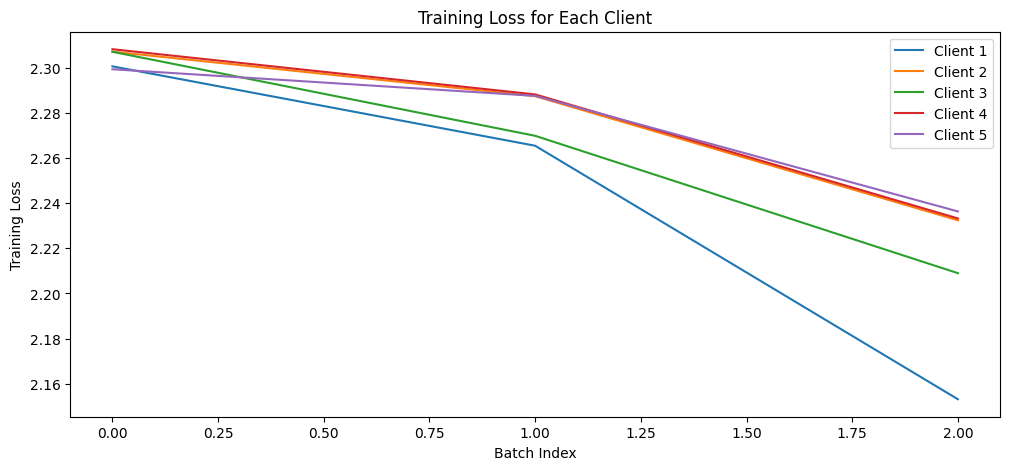

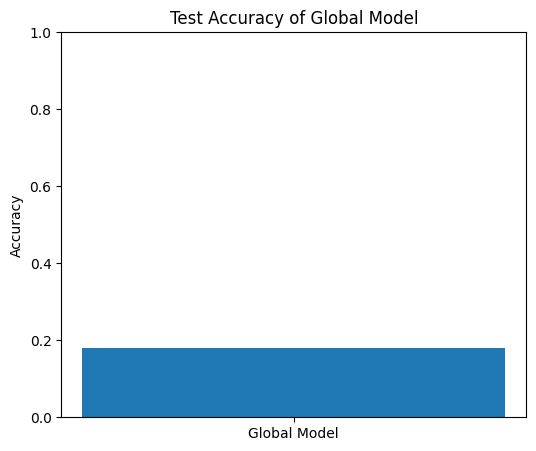

In [7]:
federated_learning()